In [1]:
using DataFrames, CSV, DelimitedFiles, Plots, FFTW
include("/home/kirk/Documents/research/CHANDRATest/DJM.jl")

Main.DJM

In [2]:
function pdot(f) #change in period due to accretion, serious estimating involved
    Pdot2 = -2  #seconds/year
    Pdot1 = -5
    P1 = 0
    P2 = 3
    plog=log10(1/f)

    dpdot = (Pdot2 - Pdot1)/(P2-P1)
    logpdot = Pdot1 + (plog-P1)*dpdot
    return(10^logpdot)
end

pdot (generic function with 1 method)

In [3]:
using Formatting
#Note: running this function for pows8 took ~2.5min on my laptop
function createPowMatrix(powList)
    n=ceil(maximum(powList.power[:]))
    df=0.0001
    nk=ceil(maximum(powList.freq[:])/df)
    powMatrix=zeros(101,101,Int(nk)+1) #any power greater than 100 will go in 101,nk for freq z direction, +1 because 1 is for normal matrix
    justPow=powList.power[:]
    errorCount=0
    counter=0
    for i in 1:length(justPow)
        print(format(i/length(justPow)*100,precision=2),"% complete\r") #output % tracker
        if ceil(powList.power[i])>100
            currentRow=101 #power is too big
        else
            currentRow=ceil(powList.power[i]) #row index for use later
        end
        
        for j in (i+1):length(justPow) #i+1 accounts for indistinguishability
            counter+=1
            if ceil(powList.power[j])>100
                currentCol=101 #other power too big
            else
               currentCol=ceil(powList.power[j]) #column index for use later
            end
            try #need to use try statement because gcdist breaks sometimes?
                rdist = DJM.gcdist(powList.ra[j],powList.dec[j],powList.ra[i],powList.dec[i])
                if (rdist*60.0 > 0.01666) #not in the same place
                    powMatrix[Int(currentRow),Int(currentCol),1]+=1 #found a pair, doesn't account for overcounting (indistinguishability)
                    #stuff below for freq z part of matrix
                    fAvg=(powList.freq[i]+powList.freq[j])/2
                    fAvgDot=1/pdot(fAvg)
                    dt=abs(powList.exptime[i]-powList.exptime[j]) #is exptime the timestamp?
                    fRangeMax=fAvgDot*dt
                    fRangeMin=fAvgDot*(-dt)
                        if fAvg>=fRangeMin && fAvg<=fRangeMax
                            kInd=ceil(fAvg/df)                                
                            #println(kInd," successfully appended to k index") note: it does work!
                            powMatrix[Int(currentRow),Int(currentCol),Int(kInd+1)]+=1 #kInd+1 because 1 is base matrix
                        end
                end
            catch
                errorCount+=1 #this error is because it tries to take acos of #>1 (I think) in gcdist
                              #maybe because of rounding errors?
            end
        end
    end
    println(errorCount," total errors accumulated")
    println(errorCount/counter*100,"% error")
    return powMatrix
end

createPowMatrix (generic function with 1 method)

In [4]:
pows12=CSV.read("cxc.fftinfo.all12")

,obsid,srcnum,startdate,exptime,ra,dec,freq,power
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1026,26,51833.8,6458.48,19.9382,-73.4501,0.00123975,13.2664
2,1028,105,51856.5,6324.74,19.038,-73.414,0.000316292,13.824
3,1028,113,51856.5,6324.74,18.9547,-73.4035,0.00110873,31.303
4,1028,113,51856.5,6324.74,18.9547,-73.4035,0.00126712,12.1519
5,1028,38,51856.5,6324.74,19.8812,-73.5169,0.00110816,21.5887
6,1028,88,51856.5,6324.74,19.1853,-73.4323,0.000316454,12.6433
7,1029,13,52024.6,6120.26,19.6143,-73.4658,0.00115807,56.0898
8,1030,14,52025.6,6152.72,19.6181,-73.4675,0.00114639,74.6027
9,1030,14,52025.6,6152.72,19.6181,-73.4675,0.00212901,18.2923


In [5]:
bgrnd12=createPowMatrix(pows12)

0 total errors accumulated
0.0% error


101×101×1545 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …    0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0    0.0    0.0    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     204.0  391.0  408.

### Functions in cells below build on each other culminating with function generateAllProb which takes a background map (as generated with createPowMatrix) and creates a massive probability distribution for each power in general and at each frequency slice.

In [75]:
function get_probability(bgrndMap,pair,freqBin)
    pow1,pow2=pair[1],pair[2]
    if freqBin==0
        kInd=1 #first slice is general map #THIS IS REDUNDANT BULLSHIT
    else
        kInd=freqBin+1 #frequency specific bins start 1 slice back
    end
    omegaTotal=sum(bgrndMap[:,:,kInd]) #total # of microstates in slice
    omegaPow=bgrndMap[pow1,pow2,kInd]
    if omegaTotal==0 #sometimes there are no 
        p=0 
    else
        p=omegaPow/omegaTotal #probability equals # in microstate/total # of possibilities
    end
    return p
end

get_probability (generic function with 1 method)

In [7]:
get_probability(bgrnd12,[13,101],0)
prob12withOther=zeros(101) #powList goes up to 101 and since using 12 anything less than that will be zero by default. 
#need to use 13 here because of ceiling function
for i in 13:101
    prob12withOther[i]=get_probability(bgrnd12,[13,i],0)
end

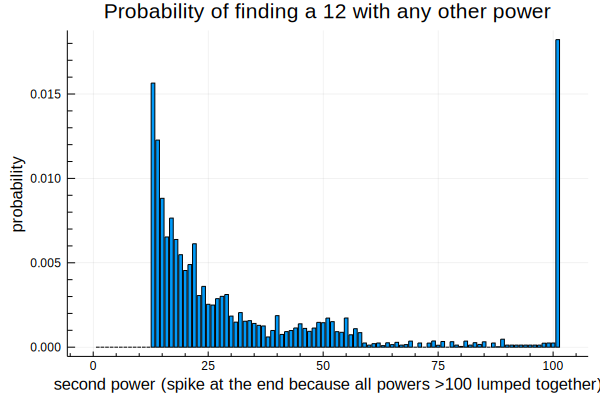

In [8]:
bar(prob12withOther,label="")
plot!(title="Probability of finding a 12 with any other power",minorticks=true,xlabel="second power (spike at the end because all powers >100 lumped together)",ylabel="probability")

In [10]:
function generateProbList4Pow(bgrndMap,pow,freqbin)
    probPowWOthers=zeros(size(bgrndMap)[1])
    for i in 1:length(probPowWOthers)
        probPowWOthers[i]=get_probability(bgrndMap,[pow,i],freqbin)
    end
    return probPowWOthers
end

generateProbList4Pow (generic function with 1 method)

In [59]:
function generateProbALLPow(bgrndMap,freqbin)
    powList=range(1,stop=101,length=101) #pow bins are 1-100 with 101 representing all pow >100
    probMatrix=zeros(length(powList),length(powList))
    for pow in powList
        probMatrix[:,Int(pow)]=generateProbList4Pow(bgrndMap,Int(pow),freqbin) #column = results of prob function
    end
    return probMatrix
end

generateProbALLPow (generic function with 1 method)

In [73]:
function generateAllProb(bgrndMap)
    nk=size(bgrndMap)[3] #size of k
    nij=size(bgrndMap)[1] #size of i,j
    probMatrix=zeros(nij,nij,nk)
    for freqbin=0:(nk-1) #start at 0 because of how I defined kInd in get_probability fx
        kInd=freqbin+1
        print(format(kInd/nk*100,precision=2),"% complete\r")
        probMatrix[:,:,kInd]=generateProbALLPow(bgrndMap,freqbin)
    end
    return probMatrix
end

generateAllProb (generic function with 1 method)

In [78]:
test=generateAllProb(bgrnd12)

101×101×1545 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0       
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.93879e-5  1.93879e-5  0.0025

In [79]:
sum(test[:,:,1]) #proves that each slice's probability does indeed add to 1

1.0000000000000002